In [1]:
%matplotlib inline

In [2]:
%load_ext line_profiler

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# AC Stark Maps #

This notebook contains a primer on how to generate Stark maps of Rydberg states when driven by an AC electric field.
Presently, only two types of solvers are implemented:

- Shirley's Time-Independent Floquet Hamiltonian
- The approximate RWA-model, which assumes a sum of 2-level systems

Potential extensions of this functionality could include:

- Two (or more) simultaneous frequenices via Shirley's method
- Time-dependent integration of the Floquet Hamiltonian's propagator
- Including optically-coupled states not in the Rydberg manifold

## Shirley's Time-Independent Floquet Hamiltonian ##

The problem of solving for AC Stark shifts in a large manifold of Rydberg states that can couple to a single RF readily lends itself to a Floquet treatment. Beginning with the time-dependent Shrödinger equation

$$ \left[H_0+V(t)\right] \Psi(t) = i\hbar \frac{\partial}{\partial t}\Psi(t) $$

we assume that the time-dependent perturbation to the bare Hamiltonian is periodic in time such that $\omega_{rf}\tau = 2\pi$ and $V(t+\tau) = V(t)$. Under this assumption, solutions to the Shrödinger equation will be periodic as well:

$$ \Psi(t) = e^{-i \epsilon t/\hbar} \Phi(t) $$

where $\epsilon$ are known as quasi-energies and $\Phi(t+\tau) = \Phi(t)$ represent periodic functions for the drive frequency.

We can define the basis in terms of the basis of $H_0$ and the Fourier vectors as $|\alpha\rangle$ and $|n\rangle$, respectively. The Hamiltonian and wave vectors, in this basis, are defined as

$$ \langle\alpha|\Psi(t)|\beta\rangle = \sum^\infty_{n=-\infty}\Phi^{(n)}_{\alpha\beta}e^{in\omega_{rf} t}e^{-i\epsilon_\beta t/\hbar} $$

$$ \langle\alpha|H(t)|\beta\rangle = \sum^\infty_{n=-\infty}H^{[n]}_{\alpha\beta}e^{in\omega_{rf} t} $$

where $H^{[n]}$ represents the $n$th-order component of the Fourier expansion of the Hamiltonian.

By subsitution of the quantities into the Shrödinger equation, we can produce an infinite-dimension eigenvalue equation that is time-independent.

$$ \sum_{\gamma m}\langle\alpha n|H_F|\gamma m\rangle\Phi^{(m)}_{\gamma \beta}=\epsilon_\beta\Phi^{(n)}_{\alpha\beta} $$

where $H_F$ is block tri-diagonal with elements

$$ \langle\alpha n|H_F|\beta m\rangle = H^{[n-m]}_{\alpha\beta}+n\hbar\omega_{rf}\delta_{\alpha\beta}\delta_{nm} $$

Finding the eigenvalues and eigenvectors of this Shirley Floquet Hamiltonian allows us to determine the steady-state basis in the presence of the RF field. Comparing how the energy levels have changed relative to $H_0$ gives the AC Stark shifts.

This theory is described in more detail by [Chu, Adv in At and Mol Phys 21 (1985)](http://www.sciencedirect.com/science/article/pii/S0065219908601438) and the application of this method to Rydberg atoms is shown in [Meyer et. al. J Phys B 53 034001 (2020)](https://doi.org/10.1088/1361-6455/ab6051).

### Example AC Stark Map using Shirley's Floquet Method ###

This example calculates the steady-state Stark shifts of the $|56D_{5/2}\rangle$ state when driven by a relatively weak far-from resonance field of 1.72 GHz with a linear polarization. It calculates the independent response of each available $m_J$ of the target state.

In [2]:
from arc import Rubidium85,ShirleyMethod

In [3]:
atom = Rubidium85()

g = [5,0,0.5]
i = [5,1,1.5]
t = [56,2,2.5]

mjs = [2.5, 1.5, 0.5]

nwin = 10
lmax = 20

q = 0

In [4]:
Esteps = 600
dBRange = 20  # calculate range spanning 20 dB of RF power
Emax = 30  # V/m
Emin = Emax*10**(-dBRange/20)
Efields = np.linspace(Emin,Emax,Esteps)

freq = 1.72e9  # in Hz, of the RF field

Given the field is very far-detuned, the resulting Stark shifts are fairly small and allow a reduction of the basis of Rydberg states in the calculation to just dipole-allowed transitions. This greatly speeds up the calculation.

In [5]:
results = {}
for mj in mjs:
    m = ShirleyMethod(atom)
    m.defineBasis(*t,mj,q,t[0]-nwin,t[0]+nwin+1,lmax,
                  edN=1,
                  progressOutput=False,debugOutput=False)
    m.defineShirleyHamiltonian(fn=1)
    m.diagonalise(Efields,freq,progressOutput=True)
    results[mj] = -m.targetShifts*1e-6 # get results in MHz

Finding eigenvectors...
Finding eigenvectors...
Finding eigenvectors...


Text(0, 0.5, 'AC Stark Shift (MHz)')

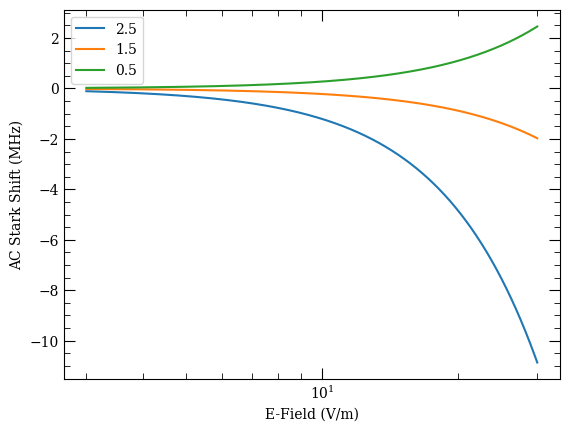

In [6]:
fig, ax = plt.subplots(1)

for mj, result in results.items():
    ax.plot(Efields, result, label=f'{mj:.1f}')
    
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('E-Field (V/m)')
ax.set_ylabel('AC Stark Shift (MHz)')

The ACStarkMap object saves more information about the solves that just the target state shifts. It also saves the full eigenvalues and eigenvectors from the diagonalisation of the Shirley Hamiltonian. It will also calculate the transition probability to go from the target state to any state in the basis.

In [7]:
print(f'For the mJ = {m.mj:.1f} calculation')
print(f'For f = {freq*1e-9:.2f} GHz')
print(f'For E = {Efields[-1]:.1f} V/m')

indMaxProb = m.transProbs[-1].argmax()
print(f'State with largest overlap with the target state is: {m.basisStates[indMaxProb]}')

For the mJ = 0.5 calculation
For f = 1.72 GHz
For E = 30.0 V/m
State with largest overlap with the target state is: [56, 2, 2.5, 0.5]


Given the small shifts and far-detuned field, it is expected that little population would be driven to another state.

### Example AC Stark Map versus Frequency ###

Here we calculate Stark shifts of the same target state, but over a range of drive frequencies with two distinct amplitudes.

Note that the drive frequencies cover four distinct resonances as well as large regions where the drive is far from all resonances.
Smoothly handling these transitions is the power of a Floquet approach to these types of calculations.

In [8]:
atom = Rubidium85()

g = [5,0,0.5]
i = [5,1,1.5]
t = [56,2,2.5]

mjs = [2.5, 1.5, 0.5]

nwin = 10
lmax = 20

q = 0

In [9]:
Efields = np.array([0.01, 0.1])

freqs = np.linspace(9e9, 35e9, 600)

In [10]:
calc = ShirleyMethod(atom)
calc.defineBasis(*t,mj,q,t[0]-nwin,t[0]+nwin+1,lmax,
              edN=1,
              progressOutput=False,debugOutput=False)
calc.defineShirleyHamiltonian(fn=1)
calc.diagonalise(Efields,freqs,progressOutput=True)

Finding eigenvectors...


In [11]:
calc.targetShifts.shape

(2, 600)

Text(0, 0.5, 'Stark Shift (Hz)')

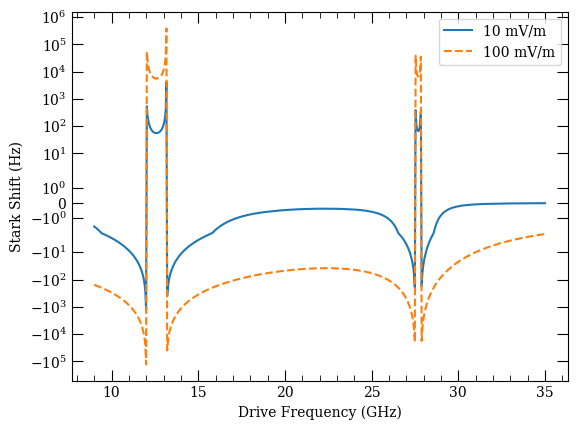

In [12]:
fig, ax = plt.subplots(1)

ax.plot(freqs*1e-9, calc.targetShifts[0], label=f'{Efields[0]*1e3:.0f} mV/m')
ax.plot(freqs*1e-9, calc.targetShifts[1], '--', label=f'{Efields[1]*1e3:.0f} mV/m')

ax.legend()
ax.set_yscale('symlog')
ax.set_xscale('linear')

ax.set_xlabel('Drive Frequency (GHz)')
ax.set_ylabel('Stark Shift (Hz)')

### Comparison with StarkMap ###

For very low frequency fields that are far-detuned from all resonances, Shirley's method will reproduce the results from ARC's `StarkMap`, differing only by a factor of $\sqrt{2}$. In other words, the following two approaches give the same result:

1) DC Stark Shift with the rms field amplitude
2) AC Stark Shift with the field amplitude

Below we show the Stark Map calculation using both methods for a drive frequency of 50 MHz.

In [13]:
from arc import StarkMap

In [14]:
atom = Rubidium85()

g = [5,0,0.5]
i = [5,1,1.5]
t = [56,2,2.5]

mj = 0.5

nwin = 10
lmax = 20

q = 0

In [15]:
Efields = np.linspace(3, 30, 100)
freq = 50e6

#### DC Stark Calculation ####

In [16]:
calc_dc = StarkMap(atom)

In [17]:
calc_dc.defineBasis(*t, mj, t[0]-nwin, t[0]+nwin+1, lmax, progressOutput=True)

Found  861  states.
Generating matrix...
100%



0

Note that the RF field amplitude is manually changed to the rms amplitude here. When the RF frequency is faster than the atomic response, the atoms will only see the rms field amplitude, not the full peak-to-peak amplitude that is implicitely assumed by the DC calculation.

In [18]:
calc_dc.diagonalise(Efields/np.sqrt(2), progressOutput=True)

Finding eigenvectors...
100%



#### AC Stark Calculation ####

In [19]:
calc_ac = ShirleyMethod(atom)

In [20]:
calc_ac.defineBasis(*t,mj,q,t[0]-nwin,t[0]+nwin+1,lmax,
                    progressOutput=True)
calc_ac.defineShirleyHamiltonian(fn=1)

Found  861  states.
Generating matrix...
100%
Energies and Couplings Generated


Note that the Shirley calculation is significantly slower than the DC StarkMap calculation despite having the same number of basis states. This is because Shirley's Floquet Hamiltonian is actually three times larger ($3\times861=2583$), making the eigenvalue solves slower.

In [21]:
calc_ac.diagonalise(Efields, freq, progressOutput=True)

Finding eigenvectors...


#### Compare ####

In [22]:
print(f'Target state zero-field energy {calc_ac.targetEnergy*1e-9:.3f} GHz')

Target state zero-field energy -1101.368 GHz


In [23]:
# extracts equivalent of `targetShifts` from `StarkMap` calculation
calc_dc_shifts = (calc_ac.targetEnergy*1e-9 - np.asarray(calc_dc.y))*1e3  # converts to MHz as well
targetEigInd = np.argmin(np.abs(calc_dc_shifts[0]))
calc_dc_targetShifts = calc_dc_shifts[:,targetEigInd]

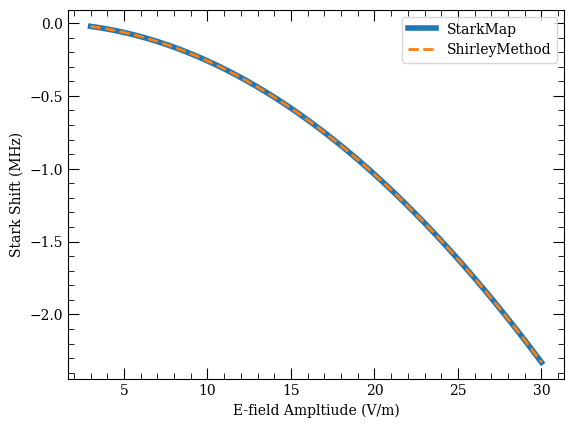

In [24]:
fig, ax = plt.subplots(1)

ax.plot(Efields, calc_dc_targetShifts, lw=4, label='StarkMap')
ax.plot(Efields, calc_ac.targetShifts*1e-6, '--', lw=2, label='ShirleyMethod')

ax.set_xlabel('E-field Ampltiude (V/m)')
ax.set_ylabel('Stark Shift (MHz)')
ax.legend()

## RWAStarkShift: Approximating AC Stark Map Calculations ##

If the Stark shifts due to the applied field are small, it is generally possible to make simplifying approximations that greatly speed up the calculation.

In [25]:
from arc import RWAStarkShift

In [26]:
atom = Rubidium85()

g = [5,0,0.5]
i = [5,1,1.5]
t = [56,2,2.5]

mj = 0.5

nwin = 10
lmax = 10

q = 0

In [27]:
freqs = np.linspace(-0.5e9, 1.5e9, 400) + 12e9
eField = 0.1  # V/m

#### Full basis solve ####

This is the full basis solve including any Rydberg state with principle quantum number $\pm10$ and $L<10$.

In [28]:
%%time

calc_full = ShirleyMethod(atom)
calc_full.defineBasis(*t,mj,q,t[0]-nwin,t[0]+nwin+1,lmax,
                  edN=0, progressOutput=True)
calc_full.defineShirleyHamiltonian(fn=1)
calc_full.diagonalise(eField, freqs, progressOutput=True)

Found  441  states.
Generating matrix...
100%
Energies and Couplings Generated
Finding eigenvectors...
CPU times: user 38min 4s, sys: 1min 27s, total: 39min 32s
Wall time: 5min 47s


Text(0, 0.5, 'AC Stark Shift (MHz)')

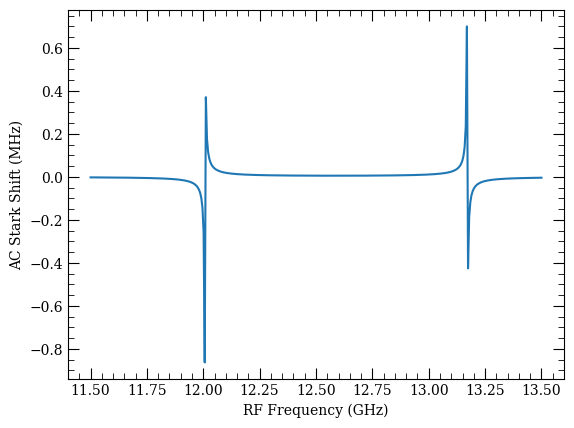

In [29]:
fig, ax = plt.subplots(1)

ax.plot(freqs*1e-9, calc_full.targetShifts*1e-6)
ax.set_xlabel('RF Frequency (GHz)')
ax.set_ylabel('AC Stark Shift (MHz)')

The assymmetric resonances are due to course grid relative to the resonance widths.

#### Reduced basis solve ####

Here is a reduced basis calculation that only includes states with a coupling to the target state that is dipole-allowed via a single photon.

In [30]:
%%time

calc_reduced = ShirleyMethod(atom)
calc_reduced.defineBasis(*t,mj,q,t[0]-nwin,t[0]+nwin+1,lmax,
                         edN=1, progressOutput=True)
calc_reduced.defineShirleyHamiltonian(fn=1)
calc_reduced.diagonalise(eField, freqs, progressOutput=True)

Found  64  states.
Generating matrix...
100%
Energies and Couplings Generated
Finding eigenvectors...
CPU times: user 1min 10s, sys: 2.29 s, total: 1min 13s
Wall time: 12.9 s


Text(0, 0.5, 'AC Stark Shift (MHz)')

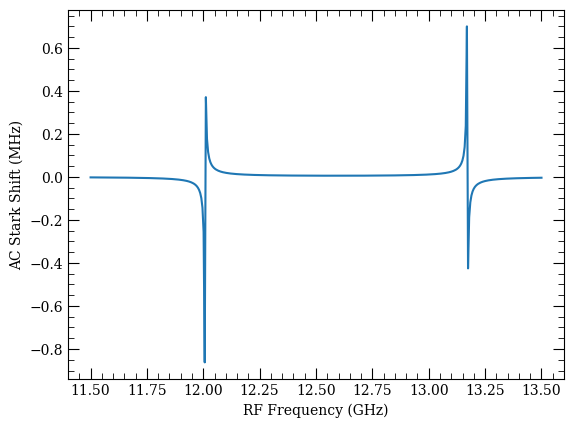

In [31]:
fig, ax = plt.subplots(1)

ax.plot(freqs*1e-9, calc_reduced.targetShifts*1e-6)
ax.set_xlabel('RF Frequency (GHz)')
ax.set_ylabel('AC Stark Shift (MHz)')

#### RWA model solve ####

A significantly faster approximation can be made by simply assuming the 2-level rotating wave approximation result holds for each dipole-allowed transition, with the shift from each state pair being added linearly.

$$ d\omega = \sum d\omega_i = \sum \frac{\delta_i\pm\sqrt{\delta_i^2+\Omega_i^2}}{2} $$

Note that the sign of $\delta_i$ and the sign in the equation depends on whether the target state is higher or lower in energy than the coupled state.

This method is significantly faster, though certainly limited in its accuracy.

In [33]:
%%time

calc_rwa = RWAStarkShift(atom)
calc_rwa.defineBasis(*t,mj,q,t[0]-nwin,t[0]+nwin+1,lmax,edN=1,progressOutput=False,debugOutput=False)
calc_rwa.findDipoleCoupledStates(debugOutput=True)
calc_rwa.makeRWA(eField, freqs)

Found 63 dipole coupled states
Nearest dipole coupled state is detuned by: 12.007 GHz
Calculating RWA Stark Shift approximation with 63 levels
CPU times: user 1.98 s, sys: 149 ms, total: 2.13 s
Wall time: 2.19 s


Text(0, 0.5, 'Stark Shift (GHz)')

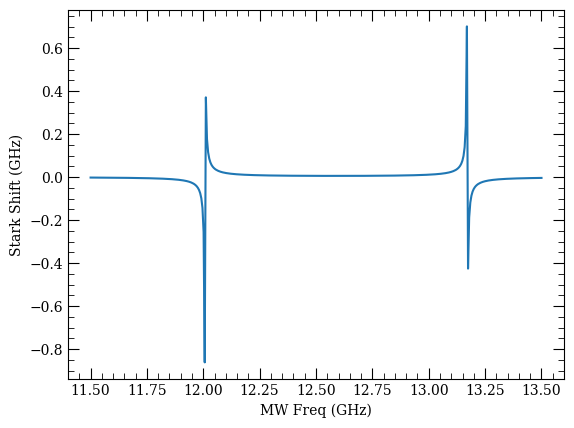

In [34]:
fig, ax = plt.subplots(1)

ax.plot(freqs*1e-9, calc_rwa.starkShifts*1e-6)
ax.set_xlabel('MW Freq (GHz)')
ax.set_ylabel('Stark Shift (GHz)')

#### Comparison ####

Comparing the two approximate methods to the full method shows the relative accuracy.

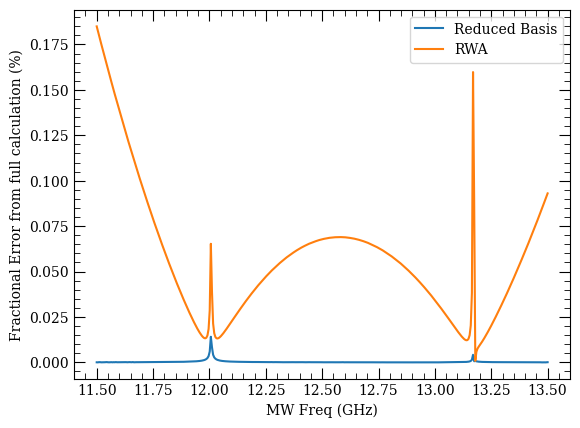

In [35]:
fig, ax = plt.subplots(1)

ax.plot(freqs*1e-9, np.abs((calc_full.targetShifts - calc_reduced.targetShifts)/calc_full.targetShifts)*100, label='Reduced Basis')
ax.plot(freqs*1e-9, np.abs((calc_full.targetShifts - calc_rwa.starkShifts)/calc_full.targetShifts)*100, label='RWA')
ax.set_xlabel('MW Freq (GHz)')
ax.set_ylabel('Fractional Error from full calculation (%)')
ax.legend()